In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('../Dataset/FPT.csv')
df.head(10)

,date,close,volume,open,high,low
0,2025-04-29,109.4,2945500,109.6,110.5,109.1
1,2025-04-28,109.5,3853700,112.0,112.4,109.2
2,2025-04-25,112.4,5384100,112.0,112.4,110.2
3,2025-04-24,112.0,7740100,111.5,113.7,110.6
4,2025-04-23,110.4,5710800,111.7,111.7,107.7
5,2025-04-22,110.4,9127300,111.0,111.2,104.0
6,2025-04-21,111.7,4332300,112.0,112.5,110.0
7,2025-04-18,111.6,7485500,110.5,115.0,110.5
8,2025-04-17,109.4,8580100,105.0,111.3,104.9
9,2025-04-16,107.9,18032200,114.5,115.9,107.9


In [3]:
df['tradingdate'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
new_dataset = df[['tradingdate','volume']]
new_dataset.index = new_dataset['tradingdate']

In [ ]:
new_dataset.head(5)

## RSI Computing

In [4]:
change = df['close'].diff()
change.dropna(inplace=True)
change.head()

1    0.1
2    2.9
3   -0.4
4   -1.6
5    0.0
Name: close, dtype: float64

In [5]:
#make 2 copies of change
change_up = change.copy()
change_down = change.copy()


In [6]:
change_up[change_up < 0] = 0
change_down[change_down > 0] = 0
change.equals(change_up+change_down)
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

#calculate rsi
rsi = 100 * avg_up /(avg_up + avg_down)
rsi.head(20)



1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14    43.952802
15    43.529412
16    50.769231
17    51.918159
18    62.608696
19    60.631579
20    59.957173
Name: close, dtype: float64

In [7]:
print(len(rsi))

4577


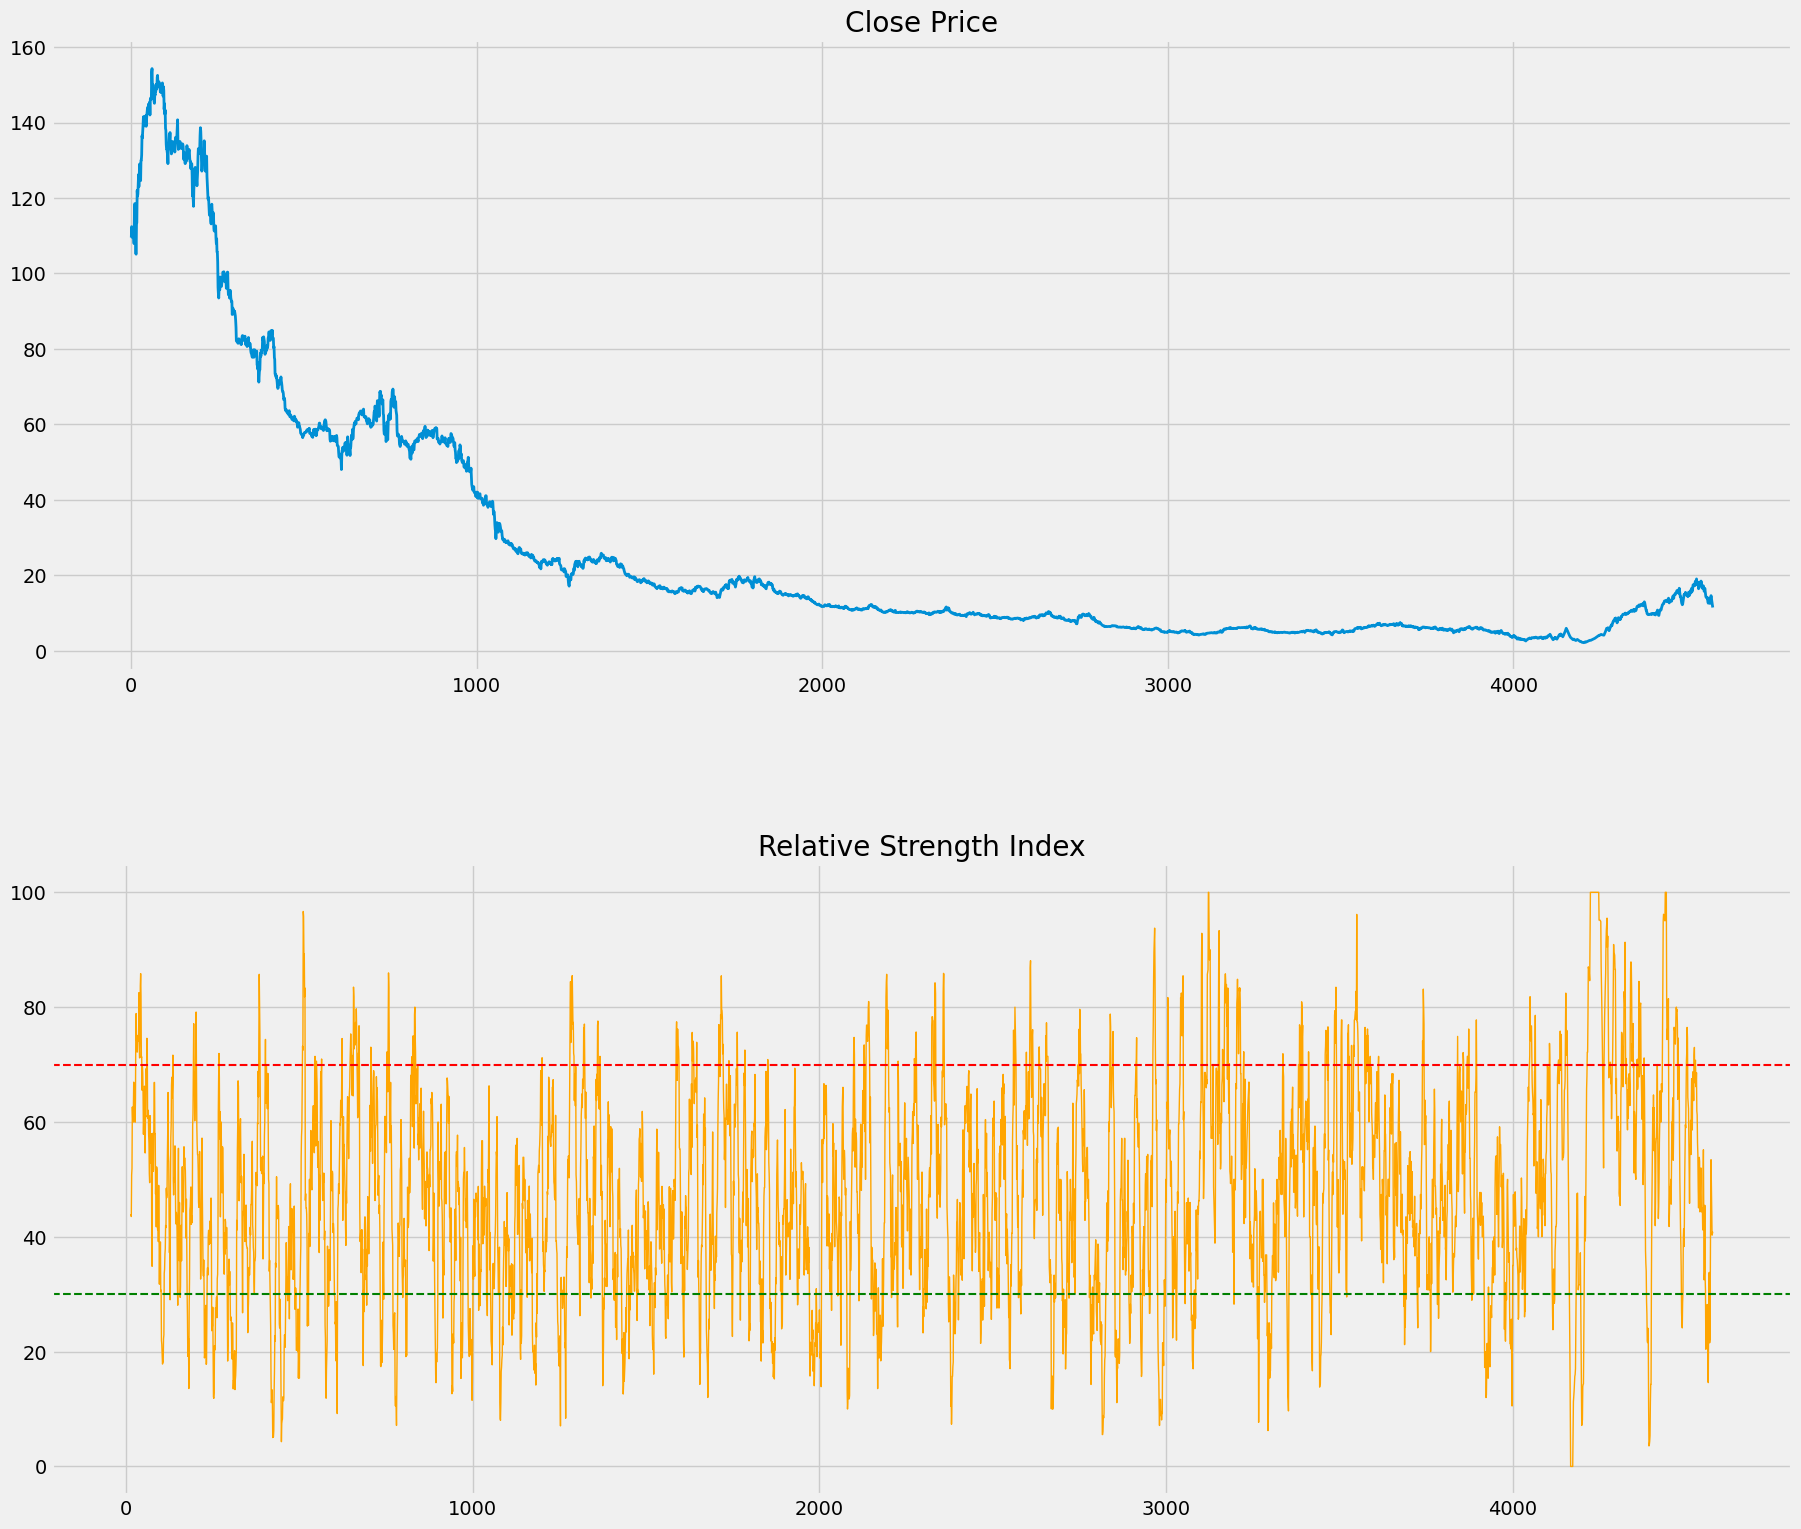

In [8]:
#plot the graph
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (20, 20)

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)


ax1.plot(df['close'], linewidth=2)
ax1.set_title('Close Price')

ax2.set_title('Relative Strength Index')
ax2.plot(rsi, color='orange', linewidth=1)

ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')

## Trading agent

In [9]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,109.4000,NaN,NaN
1,0.0,109.5000,NaN,NaN
2,0.0,112.4000,NaN,NaN
3,0.0,112.0000,NaN,NaN
4,0.0,110.4000,NaN,NaN
...,...,...,...,...
4573,0.0,13.8962,19.0144,2.1068
4574,0.0,13.2386,19.0144,2.1068
4575,0.0,12.6095,19.0144,2.1068
4576,0.0,12.0091,19.0144,2.1068


In [10]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [11]:
states_buy, states_sell, total_gains, invest = buy_stock(df.close, signals['signal'])

day 459: buy 1 units at price 62.513200, total balance 9937.486800
day 460: buy 1 units at price 62.003200, total balance 9875.483600
day 464: buy 1 units at price 61.711700, total balance 9813.771900
day 465: buy 1 units at price 61.566000, total balance 9752.205900
day 466: buy 1 units at price 61.274600, total balance 9690.931300
day 471: buy 1 units at price 60.910300, total balance 9630.021000
day 476: buy 1 units at price 60.837400, total balance 9569.183600
day 479: buy 1 units at price 60.546000, total balance 9508.637600
day 482: buy 1 units at price 59.234500, total balance 9449.403100
day 489: buy 1 units at price 59.015900, total balance 9390.387200
day 490: buy 1 units at price 58.651600, total balance 9331.735600
day 491: buy 1 units at price 57.631600, total balance 9274.104000
day 492: buy 1 units at price 57.558700, total balance 9216.545300
day 493: buy 1 units at price 57.485900, total balance 9159.059400
day 494: buy 1 units at price 57.194500, total balance 9101.86

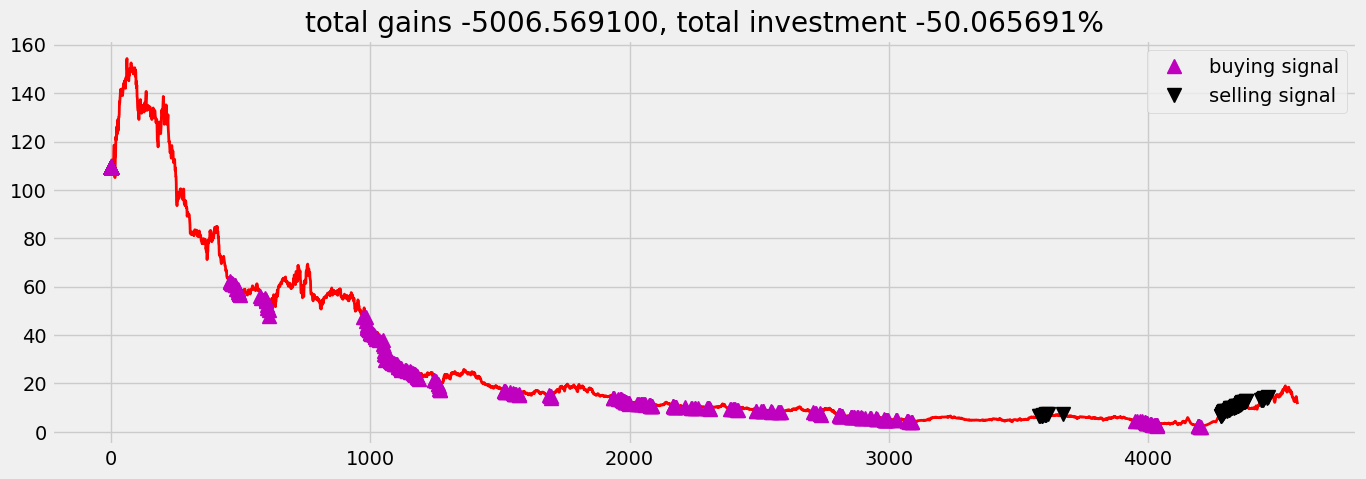

In [16]:
close = df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [12]:

def calculate_indicators(df):
    # 1. Moving Averages
    df['SMA20'] = df['close'].rolling(window=20).mean()  # 20-day Simple Moving Average
    df['SMA50'] = df['close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    
    # 2. RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 3. MACD (Moving Average Convergence Divergence)
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    return df


def generate_signals(df):
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0
    
    buy_condition = (
        (df['SMA20'] > df['SMA50']) &  # Golden cross
        (df['RSI'] < 30) &  # Oversold condition
        (df['MACD'] > df['Signal_Line'])  # MACD crossover
    )
    
    sell_condition = (
        (df['SMA20'] < df['SMA50']) |  # Death cross
        (df['RSI'] > 70) |  # Overbought condition
        (df['MACD'] < df['Signal_Line'])  # MACD crossunder
    )
    signals.loc[buy_condition, 'signal'] = 1
    signals.loc[sell_condition, 'signal'] = -1
    
    return signals

df = calculate_indicators(df)
signals = generate_signals(df)

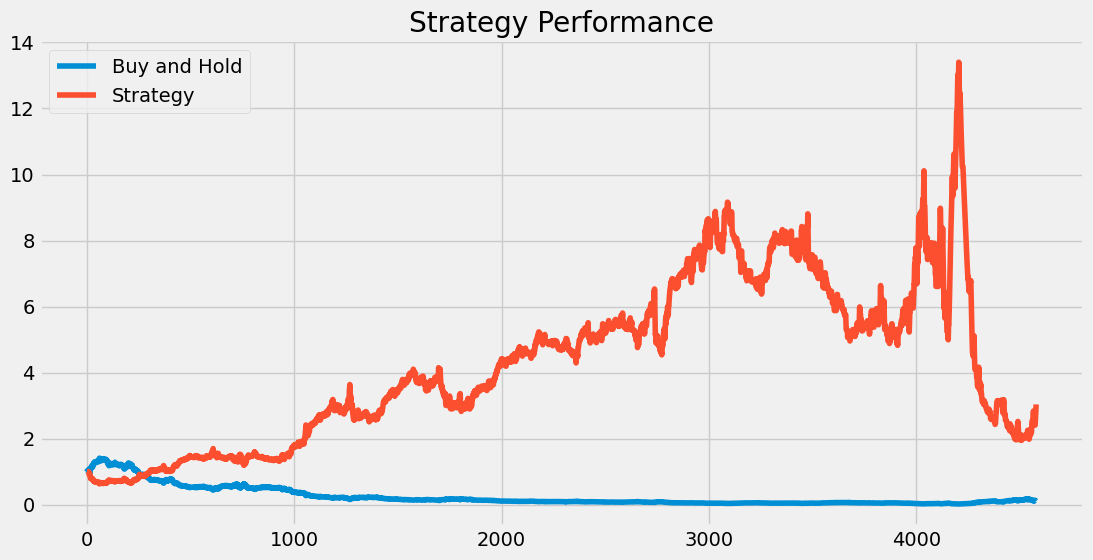

In [13]:
# Calculate returns
def calculate_returns(df, signals):
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['returns'] * signals['signal'].shift(1)
    
    # Calculate cumulative returns
    df['cumulative_returns'] = (1 + df['returns']).cumprod()
    df['strategy_cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
    
    return df

# Plot results
def plot_strategy(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['cumulative_returns'], label='Buy and Hold')
    plt.plot(df['strategy_cumulative_returns'], label='Strategy')
    plt.legend()
    plt.title('Strategy Performance')
    plt.show()

# Apply evaluation
df = calculate_returns(df, signals)
plot_strategy(df)

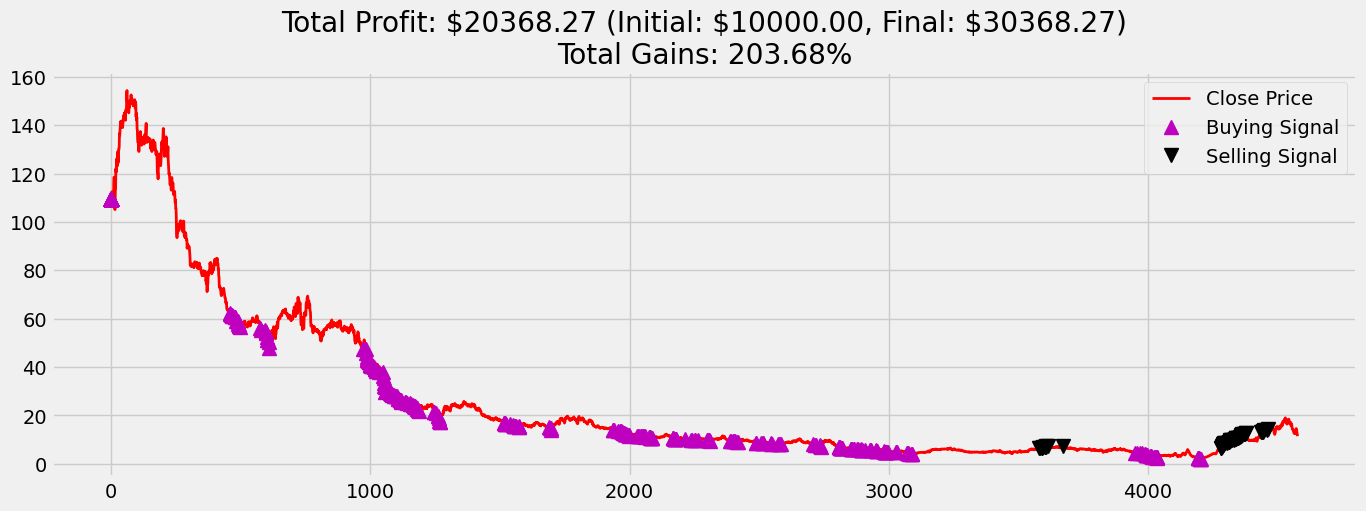

Initial Investment: $10000.00
Final Value: $30368.27
Total Profit: $20368.27
Total Gains: 203.68%


In [17]:
# Calculate actual profit in monetary terms
initial_investment = 10000  # Let's assume we start with $1000
final_value = initial_investment * df['strategy_cumulative_returns'].iloc[-1]
total_profit = final_value - initial_investment
total_gains_percentage = (df['strategy_cumulative_returns'].iloc[-1] - 1) * 100

# Create the plot
close = df['close']
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2., label='Close Price')
plt.plot(close, '^', markersize=10, color='m', label='Buying Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Selling Signal', markevery=states_sell)
plt.title(f'Total Profit: ${total_profit:.2f} (Initial: ${initial_investment:.2f}, Final: ${final_value:.2f})\nTotal Gains: {total_gains_percentage:.2f}%')
plt.legend()
plt.grid(True)
plt.show()

# Print detailed profit information
print(f"Initial Investment: ${initial_investment:.2f}")
print(f"Final Value: ${final_value:.2f}")
print(f"Total Profit: ${total_profit:.2f}")
print(f"Total Gains: {total_gains_percentage:.2f}%")

In [22]:
df

,date,close,volume,open,high,low,tradingdate,SMA20,SMA50,RSI,EMA12,EMA26,MACD,Signal_Line,returns,strategy_returns,cumulative_returns,strategy_cumulative_returns
0,2025-04-29,109.4000,2945500,109.6000,110.5000,109.1000,2025-04-29,NaN,NaN,NaN,109.400000,109.400000,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2025-04-28,109.5000,3853700,112.0000,112.4000,109.2000,2025-04-28,NaN,NaN,NaN,109.415385,109.407407,0.007977,0.001595,0.000914,0.000000,1.000914,1.000000
2,2025-04-25,112.4000,5384100,112.0000,112.4000,110.2000,2025-04-25,NaN,NaN,NaN,109.874556,109.629081,0.245475,0.050371,0.026484,0.000000,1.027422,1.000000
3,2025-04-24,112.0000,7740100,111.5000,113.7000,110.6000,2025-04-24,NaN,NaN,NaN,110.201548,109.804705,0.396843,0.119666,-0.003559,-0.000000,1.023766,1.000000
4,2025-04-23,110.4000,5710800,111.7000,111.7000,107.7000,2025-04-23,NaN,NaN,NaN,110.232079,109.848801,0.383278,0.172388,-0.014286,-0.000000,1.009141,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,2006-12-19,13.8962,137520,13.8962,13.8962,13.8962,2006-12-19,13.931975,16.033330,49.159491,13.781808,14.434021,-0.652213,-0.825196,-0.047063,0.047063,0.127022,2.522150
4574,2006-12-18,13.2386,215790,13.2386,13.2386,13.2386,2006-12-18,13.767565,15.948952,44.827817,13.698238,14.345471,-0.647234,-0.789604,-0.047322,0.047322,0.121011,2.641504
4575,2006-12-15,12.6095,265300,12.6095,12.6095,12.6095,2006-12-15,13.610300,15.855426,40.287580,13.530739,14.216881,-0.686141,-0.768911,-0.047520,0.047520,0.115261,2.767029
4576,2006-12-14,12.0091,280710,12.0091,12.0091,12.0091,2006-12-14,13.460185,15.732476,40.580096,13.296641,14.053341,-0.756700,-0.766469,-0.047615,0.047615,0.109772,2.898781


In [ ]:
import xgboost